# **Lag-Llama: PM2.5 Forecasting for Khlong Toei Station**

**Objective:** This notebook demonstrates how to use the pre-trained Lag-Llama foundation model for time series forecasting, specifically predicting **PM2.5 levels in Khlong Toei, Bangkok**. We will:
1. Set up the required environment and libraries.
2. Load and preprocess the PM2.5 data.
3. Perform zero-shot forecasting using the pre-trained model.
4. Fine-tune the model on the specific Khlong Toei dataset.
5. Compare the performance of zero-shot vs. fine-tuned models.
6. Visualize the forecast results.

**Model:** Lag-Llama (https://github.com/time-series-foundation-models/lag-llama)
**Data:** Daily PM2.5 data for Khlong Toei station(https://pm25.gistda.or.th/download)

## **1. Setup Environment**
This section clones the Lag-Llama repository, navigates into the directory, and installs all necessary Python packages listed in `requirements.txt`. We use the `-q` flag for a quieter installation process.

### **1.1 Install Lag-Llama Repository and Dependencies**

In [ ]:
# Clone the specific branch of the repository
!git clone -q -b update-gluonts https://github.com/time-series-foundation-models/lag-llama

# Change directory to the cloned repository
%cd /content/lag-llama

# Install required packages
!pip install -q -r requirements.txt

/content/lag-llama
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.8/340.8 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 48.4 MB/s eta 0:00:00


In [ ]:
# Verify installation of key libraries
!pip list | grep -E 'numpy|pandas|torch|gluonts'

gluonts                   0.16.1
numpy                     2.0.2
pandas                    2.2.2
pandas-stubs              2.2.2.240909
pytorch-lightning         2.4.0
sklearn-pandas            2.2.0
torch                     2.6.0+cpu
torch-xla                 2.6.0
torchaudio                2.6.0+cpu
torchmetrics              1.7.1
torchvision               0.21.0+cpu


### **1.2 Download Pre-trained Checkpoint**
We download the pre-trained Lag-Llama model weights (`lag-llama.ckpt`) from Hugging Face Hub. This checkpoint contains the learned parameters from the model's initial large-scale training.

In [ ]:
# Download the model checkpoint file
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama/

lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 60.1MB/s]
Download complete. Moving file to /content/lag-llama/lag-llama.ckpt
/content/lag-llama/lag-llama.ckpt


##**2. Imports and Helper Functions**

### **2.1 Import Libraries**

Importing necessary libraries for data manipulation (pandas, numpy), deep learning (torch, lightning), time series handling (gluonts), plotting (matplotlib), and utilities (os, sys, tqdm, etc.).

In [ ]:
import torch
import pandas as pd
import numpy as np
from gluonts.dataset.pandas import PandasDataset
from gluonts.evaluation import Evaluator, make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator
from matplotlib import pyplot as plt
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import matplotlib.dates as mdates
import sys
import os
from types import ModuleType
from tqdm.autonotebook import tqdm # For progress bars
from itertools import islice       # Used internally by make_evaluation_predictions
import platform, torch, lightning as L; print(platform.python_version(), torch.__version__, L.__version__)

/usr/local/lib/python3.11/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


3.11.12 2.6.0+cpu 2.4.0



### **2.2 Define the path to the downloaded checkpoint**

In [ ]:
# Define the path to the downloaded checkpoint for later use
ckpt_dir = "/content/lag-llama/"
ckpt_path_load = os.path.join(ckpt_dir, "lag-llama.ckpt")

# Check if the checkpoint file exists
if not os.path.exists(ckpt_path_load):
     # Fallback in case the directory structure is different
     ckpt_path_load = "lag-llama.ckpt"
     if not os.path.exists(ckpt_path_load):
         raise FileNotFoundError("Lag-Llama checkpoint (lag-llama.ckpt) not found in /content/lag-llama/ or the current directory.")
     else:
         print(f"Checkpoint found at fallback path: {ckpt_path_load}")
else:
    print(f"Checkpoint found at: {ckpt_path_load}")

print("✅ Environment Setup and Checkpoint Download Complete.")

Checkpoint found at: /content/lag-llama/lag-llama.ckpt
✅ Environment Setup and Checkpoint Download Complete.


### **2.3 Set Device and Helper Functions**
We set the computation device (GPU if available, otherwise CPU) and define a helper function to create dummy modules. This dummy module creation is a workaround sometimes needed for compatibility issues when loading GluonTS-related checkpoints or components in certain environments.

In [ ]:
# Set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# --- Dummy module creation ---
# This is a workaround to handle potential issues with loading GluonTS components
# if certain modules are expected but not fully available in the environment
# when loading the checkpoint directly. It avoids errors related to missing loss functions.
def create_dummy_module(module_path):
    """Creates a nested dummy module if it doesn't exist."""
    parts = module_path.split('.')
    current = ''
    parent = None
    for part in parts:
        current = current + '.' + part if current else part
        if current not in sys.modules:
            module = ModuleType(current)
            sys.modules[current] = module
            if parent:
                setattr(sys.modules[parent], part, module)
        parent = current
    return sys.modules[module_path]

# Create the dummy loss module structure
gluonts_module = create_dummy_module('gluonts.torch.modules.loss')

In [ ]:
# Define dummy loss classes that mimic expected structure but do nothing
class DistributionLoss:
    def __init__(self, *args, **kwargs): pass
    def __call__(self, *args, **kwargs): return torch.tensor(0.0) # Return a dummy zero tensor
    def __getattr__(self, name): return lambda *args, **kwargs: None
class NegativeLogLikelihood:
    def __init__(self, *args, **kwargs): pass
    def __call__(self, *args, **kwargs): return torch.tensor(0.0) # Return a dummy zero tensor
    def __getattr__(self, name): return lambda *args, **kwargs: None

# Assign the dummy classes to the dummy module
gluonts_module.DistributionLoss = DistributionLoss
gluonts_module.NegativeLogLikelihood = NegativeLogLikelihood
print("✅ Libraries Imported and Helper Functions Defined.")

✅ Libraries Imported and Helper Functions Defined.


##**3. Load and Prepare Data**
This section handles loading the raw **PM2.5** data, cleaning it, transforming it into the required format for GluonTS, and splitting it into training and validation sets.

### **3.1 Load Raw Data**
Load the dataset from a CSV file. We specify the **encoding `ISO-8859-11`** which is often used for Thai language data.

In [ ]:
# Define paths and column names
csv_path = '/content/Khlong_Toei_PM2.5.csv'
date_col  = 'Date'     # Column containing timestamps
value_col = 'PM2.5'    # Column containing the target values
item_id_col = 'item_id' # Column to identify the time series (needed by PandasDataset)
print(f"Loading data from: {csv_path}")

Loading data from: /content/Khlong_Toei_PM2.5.csv


In [ ]:
# Load the CSV file
df = pd.read_csv(csv_path, encoding='ISO-8859-11')

# Display the first few rows and data types to understand the initial structure
print("Raw DataFrame head:")
print(df.head())
print("\nRaw DataFrame info:")
df.info()

Raw DataFrame head:
                     Source.Name           City District Sub-District  \
0  PM25_Tambon_1m_2024-01-12.csv  กรุงเทพมหานคร  คลองเตย      คลองเตย   
1  PM25_Tambon_1m_2024-01-12.csv  กรุงเทพมหานคร  คลองเตย      คลองเตย   
2  PM25_Tambon_1m_2024-01-12.csv  กรุงเทพมหานคร  คลองเตย      คลองเตย   
3  PM25_Tambon_1m_2024-01-12.csv  กรุงเทพมหานคร  คลองเตย      คลองเตย   
4  PM25_Tambon_1m_2024-01-12.csv  กรุงเทพมหานคร  คลองเตย      คลองเตย   

       PM2.5      Date  
0  36.907586  1/1/2024  
1  39.194551  2/1/2024  
2  36.326173  3/1/2024  
3  44.163000  4/1/2024  
4  36.041917  5/1/2024  

Raw DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Source.Name   481 non-null    object 
 1   City          481 non-null    object 
 2   District      481 non-null    object 
 3   Sub-District  481 non-null    object 
 4   PM2

### **3.2 Preprocess Data**
Perform essential preprocessing steps:
1.  **Convert to Datetime:** Ensure the date column is in the correct datetime format. Handle potential errors during conversion.
2.  **Handle Duplicates:** Aggregate entries with the same date (if any) by taking the mean PM2.5 value.
3.  **Ensure Daily Frequency:** Resample the data to a daily frequency ('D') to ensure consistent time steps, which is crucial for most time series models.
4.  **Impute Missing Values:** Fill any gaps created during resampling using linear interpolation. Other methods like forward-fill (`ffill`) or backward-fill (`bfill`) could also be used depending on the data characteristics.
5.  **Final Type Conversion:** Convert the target value column to `float32` as expected by PyTorch/GluonTS.
6.  **Add Item ID:** Add a static `item_id` column required by GluonTS `PandasDataset` for potentially handling multiple time series (even though we only have one here).

In [ ]:
# Convert date column to datetime objects, inferring format where possible
# dayfirst=True assumes DD/MM/YYYY format if ambiguous
# errors='coerce' will turn unparseable dates into NaT (Not a Time)
print("\nPreprocessing Step 1: Converting to Datetime...")
df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors='coerce')

# Drop rows where date conversion failed (resulting in NaT)
df = df.dropna(subset=[date_col])
print(f"Data points after initial date conversion and dropping NaT: {len(df)}")


Preprocessing Step 1: Converting to Datetime...
Data points after initial date conversion and dropping NaT: 481


In [ ]:
# --- Aggregate potentially duplicate dates ---
# If multiple readings exist for the same day, average them.
# Set the date column as the index for easier time-based operations
print("\nPreprocessing Step 2: Aggregating Duplicates (by Date)...")
df_indexed = df.set_index(date_col)

df_agg = df_indexed.groupby(level=0)[[value_col]].mean() # Group by index (Date) and calculate mean
print(f"Data points after aggregation: {len(df_agg)}")


Preprocessing Step 2: Aggregating Duplicates (by Date)...
Data points after aggregation: 466


In [ ]:
# --- Resample to ensure daily frequency and fill missing values ---
print("\nPreprocessing Step 3 & 4: Resampling to Daily Frequency and Interpolating...")
# Resample ensures we have one row per day, creating NaNs for missing days
df_resampled = df_agg.resample('D').mean()

# Interpolate fills NaNs linearly. Consider other methods if appropriate.
df_resampled[value_col] = df_resampled[value_col].interpolate(method='linear')

# Drop any remaining NaNs (e.g., at the very beginning if interpolation couldn't fill)
df_resampled = df_resampled.dropna(subset=[value_col])
print(f"Data points after resampling and interpolation: {len(df_resampled)}")


Preprocessing Step 3 & 4: Resampling to Daily Frequency and Interpolating...
Data points after resampling and interpolation: 468


In [ ]:
# --- Final preparation for GluonTS ---
print("\nPreprocessing Step 5 & 6: Final Type Conversion and Adding Item ID...")

# Ensure the target column is float32
df_resampled[value_col] = df_resampled[value_col].astype('float32')

# Add a unique identifier for this time series
df_resampled[item_id_col] = 'คลองเตย' # Use the station name as the identifier


Preprocessing Step 5 & 6: Final Type Conversion and Adding Item ID...


In [ ]:
# Reset index to bring the date back as a column, required for PandasDataset.from_long_dataframe
df_ready = df_resampled.reset_index()

print("\nPrepared DataFrame head:")
print(df_ready.head())
print(f"\nTotal data points after full preparation: {len(df_ready)}")
print("\nPrepared DataFrame info:")
df_ready.info()


Prepared DataFrame head:
        Date      PM2.5  item_id
0 2024-01-01  36.907585  คลองเตย
1 2024-01-02  39.194550  คลองเตย
2 2024-01-03  36.326172  คลองเตย
3 2024-01-04  44.162998  คลองเตย
4 2024-01-05  36.041916  คลองเตย

Total data points after full preparation: 468

Prepared DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     468 non-null    datetime64[ns]
 1   PM2.5    468 non-null    float32       
 2   item_id  468 non-null    object        
dtypes: datetime64[ns](1), float32(1), object(1)
memory usage: 9.3+ KB


### **3.3 Define Forecasting Parameters and Split Data**
Define the `prediction_length` (how many steps ahead we want to forecast) and the `validation_length` (how many recent data points to reserve for validation *before* the final test period implied by `prediction_length`).

We then split the prepared DataFrame (`df_ready`) into:
* **Training set (`df_train`):** Contains data up to `-(prediction_length + validation_length)`. Used for fine-tuning the model.
* **Validation set (`df_val`):** Contains data from the end of the training set up to `-prediction_length`. Used for monitoring fine-tuning progress (e.g., early stopping).
* **Test set (implicit):** The final `prediction_length` points of `df_ready` are used as the ground truth for evaluating the forecasts generated from the data *before* this period. `make_evaluation_predictions` handles this split internally.

In [ ]:
# Define forecasting horizons
prediction_length = 14  # Forecast the next 14 days
validation_length = 28 # Use 28 days for validation before the final prediction period

# Calculate the cutoff index for training data
train_val_cutoff = prediction_length + validation_length

In [ ]:
# --- Data Splitting (Applied to DataFrame) ---
# Ensure the dataset is long enough for the split
if len(df_ready) <= train_val_cutoff:
     raise ValueError(f"Dataset too short ({len(df_ready)} points) for prediction_length={prediction_length} and validation_length={validation_length}. Need at least {train_val_cutoff + 1} points.")

# Training data: all data except the last 'train_val_cutoff' points
print(f"Splitting DataFrame: Training data = All except last {train_val_cutoff} points.")
df_train = df_ready[:-train_val_cutoff]

# Validation data: data between the end of training and the start of the final prediction period
print(f"Splitting DataFrame: Validation data = Last {train_val_cutoff} to {prediction_length} points from the end.")
df_val = df_ready[-train_val_cutoff:-prediction_length]

# The 'test' data (last prediction_length points) is implicitly handled by make_evaluation_predictions
print(f"\nTraining DataFrame length: {len(df_train)} ({df_train[date_col].min().date()} to {df_train[date_col].max().date()})")
print(f"Validation DataFrame length: {len(df_val)} ({df_val[date_col].min().date()} to {df_val[date_col].max().date()})")
print(f"Implicit Test period starts after: {df_val[date_col].max().date()}")

Splitting DataFrame: Training data = All except last 42 points.
Splitting DataFrame: Validation data = Last 42 to 14 points from the end.

Training DataFrame length: 426 (2024-01-01 to 2025-03-01)
Validation DataFrame length: 28 (2025-03-02 to 2025-03-29)
Implicit Test period starts after: 2025-03-29


### **3.4 Create GluonTS Datasets**
Convert the Pandas DataFrames into GluonTS `PandasDataset` objects. This format is required by the Lag-Llama estimator. We create datasets for training, validation, and the full dataset (used for generating evaluation predictions across the entire timeline).

In [ ]:
# Create Training Dataset
print("\nCreating training GluonTS dataset...")
train_dataset = PandasDataset.from_long_dataframe(
    df_train,
    target=value_col,       # Specify the target column
    item_id=item_id_col,    # Specify the item ID column
    timestamp=date_col,     # Specify the timestamp column
    freq='D'                # Specify the frequency of the data (Daily)
)
print(f"✅ Training dataset created. Number of time series: {len(train_dataset)}")


Creating training GluonTS dataset...
✅ Training dataset created. Number of time series: 1


In [ ]:
# Create Validation Dataset
print("\nCreating validation GluonTS dataset...")
val_dataset = PandasDataset.from_long_dataframe(
    df_val,
    target=value_col, item_id=item_id_col, timestamp=date_col, freq='D'
)
print(f"✅ Validation dataset created. Number of time series: {len(val_dataset)}")


Creating validation GluonTS dataset...
✅ Validation dataset created. Number of time series: 1


In [ ]:
# Create Full Dataset (for evaluation using make_evaluation_predictions)
# make_evaluation_predictions requires the full history to create the appropriate
# sliding window contexts for generating forecasts over the test period.
print("\nCreating full GluonTS dataset (for evaluation)...")
dataset = PandasDataset.from_long_dataframe(
    df_ready, # Use the complete prepared dataframe
    target=value_col, item_id=item_id_col, timestamp=date_col, freq='D'
)
print(f"✅ Full dataset created. Number of time series: {len(dataset)}")


Creating full GluonTS dataset (for evaluation)...
✅ Full dataset created. Number of time series: 1


## **4. Zero-Shot Prediction (Baseline)**

In this section, we use the pre-trained Lag-Llama model *without any fine-tuning* on our specific **PM2.5** dataset. This serves as a baseline to see how well the general-purpose foundation model performs "out of the box". We test different `context_length` values, which determine how much past data the model looks at to make a prediction.

### **4.1 Load Pre-trained Model and Hyperparameters**

Load the downloaded checkpoint and extract the original hyperparameters the model was trained with. These hyperparameters (like layer count, embedding dimensions) are needed to instantiate the estimator correctly.

In [ ]:
# Load the checkpoint file, ensuring weights are loaded correctly
# map_location=device ensures the model loads onto the correct device (CPU or GPU)
# weights_only=False might be needed depending on how the checkpoint was saved (includes hyperparameters etc.)
# If you encounter errors, try weights_only=True or consult Lag-Llama documentation.
try:
    ckpt = torch.load(ckpt_path_load, map_location=device, weights_only=False)
except Exception as e:
    print(f"Failed loading with weights_only=False ({e}), trying weights_only=True...")
    try:
       ckpt = torch.load(ckpt_path_load, map_location=device, weights_only=True)
       # If weights_only=True works, you might need to define hyperparameters manually
       # based on the Lag-Llama paper/repo if they are not in the checkpoint.
       # For now, assume 'hp' extraction below works or adjust as needed.
       print("Warning: Loaded with weights_only=True. Ensure hyperparameters below are correct.")
    except Exception as e2:
       print(f"Failed loading checkpoint with both options: {e2}")
       raise

In [ ]:
print("\n--- Loading Pre-trained Model Checkpoint ---")
# Extract model hyperparameters from the checkpoint
# These define the architecture of the pre-trained model
if 'hyper_parameters' in ckpt and 'model_kwargs' in ckpt['hyper_parameters']:
    hp = ckpt['hyper_parameters']['model_kwargs']
    print("✅ Pre-trained model hyperparameters loaded:")
    # print(hp) # Optionally print all hyperparameters
else:
    # If HPs are not in the checkpoint (e.g., weights_only=True was necessary),
    # you MUST define them manually here based on the standard Lag-Llama config.
    # Example (adjust if using a different variant):
    # hp = {
    #     'input_size': 1, 'n_layer': 16, 'n_embd_per_head': 32,
    #     'n_head': 8, 'time_feat': True, 'scaling': 'mean',
    #     'context_length': 32 # Base context length
    # }
    # print("⚠️ Hyperparameters not found in checkpoint, using default values. Verify these!")
    raise ValueError("Hyperparameters not found in checkpoint. Loading failed or checkpoint format issue.")


--- Loading Pre-trained Model Checkpoint ---
✅ Pre-trained model hyperparameters loaded:


### **4.2 Setup and Run Zero-Shot Predictions for Different Contexts**

We iterate through different context lengths (`contexts_zero_shot`). For each context length:
1.  **Configure RoPE Scaling:** Adjust Rotary Position Embeddings (RoPE) if the desired context + prediction length exceeds the model's base context length. This helps the model handle longer sequences than it might have seen during pre-training.
2.  **Create Estimator:** Instantiate the `LagLlamaEstimator` with the pre-trained weights (`ckpt_path`) and the specific `context_length`. Set `lr=0` implicitly by not providing it, ensuring no training occurs.
3.  **Create Predictor:** Build the predictor object from the estimator.
4.  **Generate Forecasts:** Use `make_evaluation_predictions` to generate probabilistic forecasts (`num_samples` paths) over the test period defined by `prediction_length`. This function automatically handles iterating through the dataset and providing the correct historical context.

In [ ]:
# --- Zero-Shot Prediction Settings ---
contexts_zero_shot = [32, 64, 128] # Context lengths (history window size) to test
num_samples_pred = 100             # Number of sample paths for probabilistic forecast
batch_size_pred = 64               # Batch size during prediction inference

# Dictionaries to store predictors and results for each context length
predictors_zero_shot = {}
results_zero_shot = {} # Stores tuples: (list_of_forecasts, list_of_ground_truth_ts)

In [ ]:
print(f"\n--- Running Zero-Shot Predictions for Contexts: {contexts_zero_shot} ---")

# Loop through each specified context length
for c in contexts_zero_shot:
    print(f"\n--- Processing Zero-Shot for context_length = {c} ---")

    # --- Configure RoPE Scaling ---
    # Get the base context length the model was trained with (provide a default if missing)
    base_context_length = hp.get('context_length', 32)
    if not isinstance(base_context_length, (int, float)) or base_context_length <= 0:
        print(f"Warning: Invalid or missing 'context_length' in hyperparameters for ctx={c}. Using default: 32")
        base_context_length = 32

    # Calculate scaling factor if current context+prediction exceeds base context
    # This helps the positional embeddings generalize to longer sequences.
    rope_scaling_factor = max(1.0, (c + prediction_length) / base_context_length)
    print(f"Base context: {base_context_length}, Target context+pred: {c + prediction_length}, RoPE Factor: {rope_scaling_factor:.2f}")
    rope_args_pred = {'type': 'linear', 'factor': rope_scaling_factor}

    # --- Create Estimator ---
    # We pass the checkpoint path, prediction/context lengths, and original HPs.
    # No learning rate (lr) is specified, so it defaults to a value suitable for inference/no training.
    estimator_zero_shot = LagLlamaEstimator(
            ckpt_path=ckpt_path_load,              # Path to pre-trained weights
            prediction_length=prediction_length,   # How many steps to predict
            context_length=c,                      # How much history to use

            # Model architecture hyperparameters (from loaded checkpoint)
            input_size=hp['input_size'],           # Typically 1 for univariate time series
            n_layer=hp['n_layer'],
            n_embd_per_head=hp['n_embd_per_head'],
            n_head=hp['n_head'],
            scaling=hp.get('scaling', "mean"),     # Data scaling method used during pre-training
            time_feat=hp['time_feat'],             # Whether time features were used

            # Zero-shot specific settings
            rope_scaling=rope_args_pred,           # Apply RoPE scaling configuration
            nonnegative_pred_samples=True,         # Ensure predictions are non-negative (suitable for PM2.5)
            batch_size=batch_size_pred,            # Inference batch size
            num_parallel_samples=num_samples_pred, # Generate multiple forecast paths
            device=device                          # Set computation device
        )

    # --- Create Predictor ---
    # Build the predictor object which can be used to generate forecasts
    print(f"Creating Zero-Shot Predictor for context={c}...")
    transformation = estimator_zero_shot.create_transformation() # Data preprocessing steps
    lightning_module = estimator_zero_shot.create_lightning_module() # The core model structure
    # Set model to evaluation mode is handled internally by create_predictor
    predictor = estimator_zero_shot.create_predictor(transformation, lightning_module)
    predictors_zero_shot[c] = predictor
    print(f"✅ Predictor created.")

    # --- Generate Forecasts ---
    print(f"Running Zero-Shot Prediction for context={c}...")
    # make_evaluation_predictions iterates through the 'dataset', takes appropriate
    # history windows (based on context_length), feeds them to the predictor,
    # and collects the forecasts and corresponding ground truth series.
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,       # Use the full dataset
        predictor=predictor,   # The predictor we just created
        num_samples=num_samples_pred # Number of probabilistic samples
    )

    # Consume the iterators and store the results
    # Using tqdm provides progress bars
    print("Generating forecasts...")
    forecasts = list(tqdm(forecast_it, total=len(dataset), desc=f"ZS Forecast ctx={c}"))
    print("Collecting ground truth...")
    tss = list(tqdm(ts_it, total=len(dataset), desc=f"ZS Ground Truth ctx={c}"))

    # Store results; tss should be the same for all context lengths as it's from the original dataset
    results_zero_shot[c] = (forecasts, tss)
    print(f"✅ Zero-Shot prediction complete for context={c}.")


--- Running Zero-Shot Predictions for Contexts: [32, 64, 128] ---

--- Processing Zero-Shot for context_length = 32 ---
Base context: 32, Target context+pred: 46, RoPE Factor: 1.44
Creating Zero-Shot Predictor for context=32...
✅ Predictor created.
Running Zero-Shot Prediction for context=32...
Generating forecasts...


ZS Forecast ctx=32:   0%|          | 0/1 [00:00<?, ?it/s]

ZS Ground Truth ctx=32:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Zero-Shot prediction complete for context=32.

--- Processing Zero-Shot for context_length = 64 ---
Base context: 32, Target context+pred: 78, RoPE Factor: 2.44
Creating Zero-Shot Predictor for context=64...
✅ Predictor created.
Running Zero-Shot Prediction for context=64...
Generating forecasts...


ZS Forecast ctx=64:   0%|          | 0/1 [00:00<?, ?it/s]

ZS Ground Truth ctx=64:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Zero-Shot prediction complete for context=64.

--- Processing Zero-Shot for context_length = 128 ---
Base context: 32, Target context+pred: 142, RoPE Factor: 4.44
Creating Zero-Shot Predictor for context=128...
✅ Predictor created.
Running Zero-Shot Prediction for context=128...
Generating forecasts...


ZS Forecast ctx=128:   0%|          | 0/1 [00:00<?, ?it/s]

ZS Ground Truth ctx=128:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Zero-Shot prediction complete for context=128.


### **4.3 Evaluate Zero-Shot Predictions**

Evaluate the generated zero-shot forecasts against the actual ground truth data using the Continuous Ranked Probability Score (CRPS), accessed via `mean_wQuantileLoss` in the GluonTS evaluator. Lower CRPS indicates better probabilistic forecast accuracy.

In [ ]:
print("\n--- Evaluating Zero-Shot Predictions ---")

# Use GluonTS Evaluator with default quantile losses (calculates CRPS)
evaluator = Evaluator()
metrics_zero_shot = {} # Dictionary to store evaluation metric for each context

# Evaluate for each context length tested
for c, result in results_zero_shot.items():
    forecasts, tss = result # Unpack results
    if not tss:
        print(f"Warning: No ground truth data (tss) found for context={c}. Skipping evaluation.")
        continue
    if not forecasts:
        print(f"Warning: No forecasts found for context={c}. Skipping evaluation.")
        continue

    print(f"\nEvaluating Zero-Shot for context={c}...")
    # The evaluator compares the predicted distribution (forecasts) with the actual values (tss)
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts))

    # Extract the CRPS metric (mean weighted quantile loss)
    crps_metric = agg_metrics.get('mean_wQuantileLoss')
    metrics_zero_shot[c] = crps_metric # Store the metric

    if crps_metric is not None:
        print(f"✅ Zero-Shot CRPS (mean_wQuantileLoss) for ctx={c}: {crps_metric:.4f}")
    else:
        print(f"Warning: Metric 'mean_wQuantileLoss' not found in evaluation results for ctx={c}.")
        # print("Available metrics:", agg_metrics.keys()) # Uncomment to see available metrics


--- Evaluating Zero-Shot Predictions ---

Evaluating Zero-Shot for context=32...


Running evaluation: 1it [00:04,  4.34s/it]


✅ Zero-Shot CRPS (mean_wQuantileLoss) for ctx=32: 0.3310

Evaluating Zero-Shot for context=64...


Running evaluation: 1it [00:04,  4.40s/it]


✅ Zero-Shot CRPS (mean_wQuantileLoss) for ctx=64: 0.4033

Evaluating Zero-Shot for context=128...


Running evaluation: 1it [00:04,  4.37s/it]


✅ Zero-Shot CRPS (mean_wQuantileLoss) for ctx=128: 0.4170


## **5. Fine-Tuning**

Now, we fine-tune the pre-trained Lag-Llama model on our specific **Khlong Toei PM2.5** dataset. This involves further training the model for a small number of epochs with a low learning rate, allowing it to adapt its weights to the nuances of this particular time series. We will again iterate through different context lengths.

### **5.1 Define Fine-Tuning Hyperparameters**

Set the hyperparameters specifically for the fine-tuning process:
* `contexts_finetune`: Context lengths to experiment with during fine-tuning.
* `learning_rate`: A small learning rate is crucial for stable fine-tuning.
* `weight_decay`: Helps prevent overfitting by penalizing large weights.
* `max_epochs_finetune`: Maximum number of training epochs.
* `patience`: Number of epochs to wait for validation loss improvement before stopping early.
* `batch_size_finetune`: Batch size used during the fine-tuning training phase.

In [ ]:
# --- Fine-Tuning Settings ---
contexts_finetune = [32, 64, 128]     # Context lengths to fine-tune for
learning_rate = 1e-6                 # Fine-tuning learning rate (often smaller than pre-training)
weight_decay_finetune = 0.03          # Weight decay for regularization
max_epochs_finetune = 10              # Maximum number of epochs for fine-tuning
early_stopping_patience = 3           # Patience for early stopping based on validation loss
early_stopping_min_delta = 0.001      # Minimum change in validation loss to be considered an improvement
batch_size_finetune = 64              # Batch size for fine-tuning
# num_samples_pred remains the same (100) as defined earlier for prediction consistency
# prediction_length remains the same (7) as defined earlier

In [ ]:
# Dictionaries to store fine-tuned predictors, results, and metrics
predictors_finetuned = {}
results_finetuned = {} # Stores tuples: (list_of_forecasts, list_of_ground_truth_ts)
metrics_finetuned = {} # Stores CRPS metric

print("Fine-tuning Hyperparameters:")
print(f"  Context Lengths: {contexts_finetune}")
print(f"  Learning Rate: {learning_rate}")
print(f"  Weight Decay: {weight_decay_finetune}")
print(f"  Max Epochs: {max_epochs_finetune}")
print(f"  Early Stopping Patience: {early_stopping_patience}")
print(f"  Early Stopping Min Delta: {early_stopping_min_delta}")
print(f"  Batch Size: {batch_size_finetune}")

Fine-tuning Hyperparameters:
  Context Lengths: [32, 64, 128]
  Learning Rate: 1e-06
  Weight Decay: 0.03
  Max Epochs: 10
  Early Stopping Patience: 3
  Early Stopping Min Delta: 0.001
  Batch Size: 64


### **5.2 Fine-Tuning Loop**

This loop iterates through the specified `contexts_finetune`. For each context length (`c_ft`):

1.  **Setup Estimator:** Instantiate `LagLlamaEstimator` similar to zero-shot, but now provide the `lr` and `weight_decay`. Crucially, we still use `ckpt_path_load` to *initialize* the weights from the pre-trained model before fine-tuning starts. We also configure `trainer_kwargs` for the PyTorch Lightning trainer (epochs, accelerator, callbacks like EarlyStopping).
2.  **Train (Fine-tune):** Call the `train` method on the estimator, passing the training (`train_dataset`) and validation (`val_dataset`) GluonTS datasets. Early stopping monitors the validation loss. The method returns a `Predictor` object representing the fine-tuned model.
3.  **Predict:** Use the fine-tuned predictor to generate forecasts on the *full* dataset using `make_evaluation_predictions`, just like in the zero-shot phase.
4.  **Evaluate:** Calculate the CRPS metric for the fine-tuned forecasts using the `Evaluator`.

In [ ]:
print("\n--- Starting Fine-Tuning Loop ---")

# Loop through each context length designated for fine-tuning
for c_ft in contexts_finetune:
    print(f"\n{'='*20} Processing Fine-Tuning for context_length = {c_ft} {'='*20}")

    # --- 1. Setup Estimator for Fine-Tuning ---
    print(f"Setting up Estimator for Fine-tuning (ctx={c_ft})...")

    # Setup Early Stopping callback for this specific run
    # Monitors 'val_loss' calculated on the val_dataset during training
    early_stop_callback = EarlyStopping(
        monitor="val_loss",                # Metric to monitor
        patience=early_stopping_patience,  # How many epochs to wait for improvement
        verbose=True,                      # Print messages when stopping
        mode="min",                        # Stop when the monitored quantity stops decreasing
        min_delta=early_stopping_min_delta # Minimum change to qualify as improvement
    )

    # Create the estimator instance for fine-tuning
    estimator_finetune = LagLlamaEstimator(
        ckpt_path=ckpt_path_load,              # Initialize with pre-trained weights!
        prediction_length=prediction_length,
        context_length=c_ft,                   # Current context length

        # Fine-tuning hyperparameters
        lr=learning_rate,
        weight_decay=weight_decay_finetune,
        nonnegative_pred_samples=True,         # Ensure non-negative forecasts

        # Model architecture hyperparameters (must match pre-trained model)
        input_size=hp['input_size'],
        n_layer=hp['n_layer'],
        n_embd_per_head=hp['n_embd_per_head'],
        n_head=hp['n_head'],
        time_feat=hp['time_feat'],
        scaling=hp.get('scaling', "mean"),

        # Training settings
        batch_size=batch_size_finetune,
        num_parallel_samples=num_samples_pred, # Used during prediction after training

        # PyTorch Lightning Trainer arguments
        trainer_kwargs={
            "max_epochs": max_epochs_finetune,
            "accelerator": "gpu" if device.type == 'cuda' else 'cpu',
            "devices": 1,
            "callbacks": [early_stop_callback],    # Add the early stopping callback
            "enable_progress_bar": True,          # Show training progress
            # You might add other trainer args like gradient clipping if needed
            # "gradient_clip_val": 0.5
        },
        device=device
    )

    # --- 2. Train (Fine-tune) ---
    print(f"Starting fine-tuning (ctx={c_ft}) on {len(df_train)} training samples, validating on {len(df_val)} samples...")
    # The train method runs the training loop using the provided datasets
    # It returns a predictor instance ready for inference
    predictor_ft = estimator_finetune.train(
        training_data=train_dataset,        # Training data
        validation_data=val_dataset,      # Validation data for early stopping/monitoring
        cache_data=True,                  # Cache data in memory if possible (speeds up epochs)
        shuffle_buffer_length=1000        # Size of buffer for shuffling training data
    )
    print(f"✅ Fine-tuning finished for ctx={c_ft}.")
    predictors_finetuned[c_ft] = predictor_ft # Store the trained predictor

    # --- 3. Predict with Fine-tuned Model ---
    print(f"\nRunning Prediction with Fine-tuned Model (ctx={c_ft})...")
    # Generate forecasts using the *fine-tuned* predictor on the full dataset
    forecast_it_ft, ts_it_ft = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor_ft, # Use the fine-tuned predictor
        num_samples=num_samples_pred
    )

    # Consume iterators and store results
    print("Generating fine-tuned forecasts...")
    current_forecasts_ft = list(tqdm(forecast_it_ft, total=len(dataset), desc=f"FT Forecast ctx={c_ft}"))
    print("Collecting ground truth (should be same as before)...")
    current_tss_ft = list(tqdm(ts_it_ft, total=len(dataset), desc=f"FT Ground Truth ctx={c_ft}"))

    results_finetuned[c_ft] = (current_forecasts_ft, current_tss_ft)
    print(f"✅ Fine-tuned prediction complete for ctx={c_ft}.")

    # --- 4. Evaluate Fine-tuned Predictions ---
    print(f"\nEvaluating Fine-tuned Predictions (ctx={c_ft})...")
    # Check if ground truth exists (it should, but good practice to check)
    if not current_tss_ft:
        print(f"Skipping evaluation for fine-tuned ctx={c_ft}, no ground truth.")
        metrics_finetuned[c_ft] = None # Mark as not evaluated
        continue
    if not current_forecasts_ft:
        print(f"Skipping evaluation for fine-tuned ctx={c_ft}, no forecasts generated.")
        metrics_finetuned[c_ft] = None # Mark as not evaluated
        continue

    # Evaluate using the same evaluator instance
    agg_metrics_ft, item_metrics_ft = evaluator(iter(current_tss_ft), iter(current_forecasts_ft))

    # Extract and store the CRPS metric
    metric_ft = agg_metrics_ft.get('mean_wQuantileLoss')
    metrics_finetuned[c_ft] = metric_ft # Store the result

    if metric_ft is not None:
        print(f"✅ Fine-tuned CRPS (mean_wQuantileLoss) (ctx={c_ft}): {metric_ft:.4f}")
    else:
        print(f"Warning: Metric 'mean_wQuantileLoss' not found for fine-tuned ctx={c_ft}.")

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: True, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: True, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/setup.py:183: TPU available but not used. You can set it by doing `Trainer(accelerator='tpu')`.
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules in train mode
0         


--- Starting Fine-Tuning Loop ---

==================== Processing Fine-Tuning for context_length = 32 ====================
Setting up Estimator for Fine-tuning (ctx=32)...
Starting fine-tuning (ctx=32) on 426 training samples, validating on 28 samples...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 0.224
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 0.224
INFO: Epoch 0, global step 50: 'val_loss' reached 0.22366 (best 0.22366), saving model to '/content/lag-llama/lightning_logs/version_12/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'val_loss' reached 0.22366 (best 0.22366), saving model to '/content/lag-llama/lightning_logs/version_12/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.223
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.223
INFO: Epoch 1, global step 100: 'val_loss' reached 0.22256 (best 0.22256), saving model to '/content/lag-llama/lightning_logs/version_12/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'val_loss' reached 0.22256 (best 0.22256), saving model to '/content/lag-llama/lightning_logs/version_12/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 150: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 200: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 3 records. Best score: 0.223. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.223. Signaling Trainer to stop.
INFO: Epoch 4, global step 250: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 250: 'val_loss' was not in top 1


✅ Fine-tuning finished for ctx=32.

Running Prediction with Fine-tuned Model (ctx=32)...
Generating fine-tuned forecasts...


FT Forecast ctx=32:   0%|          | 0/1 [00:00<?, ?it/s]

FT Ground Truth ctx=32:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Fine-tuned prediction complete for ctx=32.

Evaluating Fine-tuned Predictions (ctx=32)...


Running evaluation: 1it [00:04,  4.16s/it]
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: True, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: True, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/setup.py:183: TPU available but not used. You can set it by doing `Trainer(accelerator='tpu')`.
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)

✅ Fine-tuned CRPS (mean_wQuantileLoss) (ctx=32): 0.4778

==================== Processing Fine-Tuning for context_length = 64 ====================
Setting up Estimator for Fine-tuning (ctx=64)...
Starting fine-tuning (ctx=64) on 426 training samples, validating on 28 samples...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: -0.871
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: -0.871
INFO: Epoch 0, global step 50: 'val_loss' reached -0.87088 (best -0.87088), saving model to '/content/lag-llama/lightning_logs/version_13/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'val_loss' reached -0.87088 (best -0.87088), saving model to '/content/lag-llama/lightning_logs/version_13/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 100: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 150: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 3 records. Best score: -0.871. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: -0.871. Signaling Trainer to stop.
INFO: Epoch 3, global step 200: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 200: 'val_loss' was not in top 1


✅ Fine-tuning finished for ctx=64.

Running Prediction with Fine-tuned Model (ctx=64)...
Generating fine-tuned forecasts...


FT Forecast ctx=64:   0%|          | 0/1 [00:00<?, ?it/s]

FT Ground Truth ctx=64:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Fine-tuned prediction complete for ctx=64.

Evaluating Fine-tuned Predictions (ctx=64)...


Running evaluation: 1it [00:04,  4.33s/it]
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: True, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: True, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/setup.py:183: TPU available but not used. You can set it by doing `Trainer(accelerator='tpu')`.
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)

✅ Fine-tuned CRPS (mean_wQuantileLoss) (ctx=64): 0.3529

==================== Processing Fine-Tuning for context_length = 128 ====================
Setting up Estimator for Fine-tuning (ctx=128)...
Starting fine-tuning (ctx=128) on 426 training samples, validating on 28 samples...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: -1.780
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: -1.780
INFO: Epoch 0, global step 50: 'val_loss' reached -1.77997 (best -1.77997), saving model to '/content/lag-llama/lightning_logs/version_14/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'val_loss' reached -1.77997 (best -1.77997), saving model to '/content/lag-llama/lightning_logs/version_14/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.122 >= min_delta = 0.001. New best score: -1.902
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.122 >= min_delta = 0.001. New best score: -1.902
INFO: Epoch 1, global step 100: 'val_loss' reached -1.90196 (best -1.90196), saving model to '/content/lag-llama/lightning_logs/version_14/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'val_loss' reached -1.90196 (best -1.90196), saving model to '/content/lag-llama/lightning_logs/version_14/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.153 >= min_delta = 0.001. New best score: -2.055
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.153 >= min_delta = 0.001. New best score: -2.055
INFO: Epoch 2, global step 150: 'val_loss' reached -2.05504 (best -2.05504), saving model to '/content/lag-llama/lightning_logs/version_14/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 150: 'val_loss' reached -2.05504 (best -2.05504), saving model to '/content/lag-llama/lightning_logs/version_14/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.127 >= min_delta = 0.001. New best score: -2.182
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.127 >= min_delta = 0.001. New best score: -2.182
INFO: Epoch 3, global step 200: 'val_loss' reached -2.18174 (best -2.18174), saving model to '/content/lag-llama/lightning_logs/version_14/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 200: 'val_loss' reached -2.18174 (best -2.18174), saving model to '/content/lag-llama/lightning_logs/version_14/checkpoints/epoch=3-step=200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.119 >= min_delta = 0.001. New best score: -2.301
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.119 >= min_delta = 0.001. New best score: -2.301
INFO: Epoch 4, global step 250: 'val_loss' reached -2.30060 (best -2.30060), saving model to '/content/lag-llama/lightning_logs/version_14/checkpoints/epoch=4-step=250.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 250: 'val_loss' reached -2.30060 (best -2.30060), saving model to '/content/lag-llama/lightning_logs/version_14/checkpoints/epoch=4-step=250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.114 >= min_delta = 0.001. New best score: -2.415
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.114 >= min_delta = 0.001. New best score: -2.415
INFO: Epoch 5, global step 300: 'val_loss' reached -2.41501 (best -2.41501), saving model to '/content/lag-llama/lightning_logs/version_14/checkpoints/epoch=5-step=300.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 300: 'val_loss' reached -2.41501 (best -2.41501), saving model to '/content/lag-llama/lightning_logs/version_14/checkpoints/epoch=5-step=300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.121 >= min_delta = 0.001. New best score: -2.536
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.121 >= min_delta = 0.001. New best score: -2.536
INFO: Epoch 6, global step 350: 'val_loss' reached -2.53623 (best -2.53623), saving model to '/content/lag-llama/lightning_logs/version_14/checkpoints/epoch=6-step=350.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 350: 'val_loss' reached -2.53623 (best -2.53623), saving model to '/content/lag-llama/lightning_logs/version_14/checkpoints/epoch=6-step=350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.136 >= min_delta = 0.001. New best score: -2.672
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.136 >= min_delta = 0.001. New best score: -2.672
INFO: Epoch 7, global step 400: 'val_loss' reached -2.67249 (best -2.67249), saving model to '/content/lag-llama/lightning_logs/version_14/checkpoints/epoch=7-step=400.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 400: 'val_loss' reached -2.67249 (best -2.67249), saving model to '/content/lag-llama/lightning_logs/version_14/checkpoints/epoch=7-step=400.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.153 >= min_delta = 0.001. New best score: -2.826
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.153 >= min_delta = 0.001. New best score: -2.826
INFO: Epoch 8, global step 450: 'val_loss' reached -2.82557 (best -2.82557), saving model to '/content/lag-llama/lightning_logs/version_14/checkpoints/epoch=8-step=450.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 450: 'val_loss' reached -2.82557 (best -2.82557), saving model to '/content/lag-llama/lightning_logs/version_14/checkpoints/epoch=8-step=450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 500: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 500: 'val_loss' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


✅ Fine-tuning finished for ctx=128.

Running Prediction with Fine-tuned Model (ctx=128)...
Generating fine-tuned forecasts...


FT Forecast ctx=128:   0%|          | 0/1 [00:00<?, ?it/s]

FT Ground Truth ctx=128:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Fine-tuned prediction complete for ctx=128.

Evaluating Fine-tuned Predictions (ctx=128)...


Running evaluation: 1it [00:04,  4.35s/it]


✅ Fine-tuned CRPS (mean_wQuantileLoss) (ctx=128): 0.6686


## **6. Comparison of Results**

This section presents a summary table comparing the performance (CRPS metric) of the Zero-Shot predictions versus the Fine-tuned predictions for each context length tested. We also calculate the absolute and percentage improvement achieved through fine-tuning.

In [ ]:
print("\n--- Comparison Summary: Zero-Shot vs Fine-tuned ---")

# Define the contexts we want to include in the comparison table
# Should ideally include all contexts tested in both phases
contexts_to_compare = sorted(list(set(contexts_zero_shot) | set(contexts_finetune)))

# Print table header
print("| Context | Zero-Shot CRPS | Fine-tuned CRPS | Improvement | % Improvement |")
print("|---------|----------------|-----------------|-------------|---------------|")

# Iterate through contexts and print results
for c in contexts_to_compare:
    # Retrieve metrics, using .get() with None as default if a context wasn't run/evaluated
    zs_metric = metrics_zero_shot.get(c)
    ft_metric = metrics_finetuned.get(c)

    # Format metrics for display, handling None values
    zs_str = f"{zs_metric:.4f}" if zs_metric is not None else "N/A"
    ft_str = f"{ft_metric:.4f}" if ft_metric is not None else "N/A"
    imp_str = "N/A"
    imp_pct_str = "N/A"

    # Calculate improvement if both metrics are available
    if zs_metric is not None and ft_metric is not None:
        improvement = zs_metric - ft_metric # Lower CRPS is better
        imp_str = f"{improvement:.4f}"
        # Calculate percentage improvement, handle division by zero
        imp_pct = (improvement / zs_metric * 100) if zs_metric != 0 else 0
        imp_pct_str = f"{imp_pct:.2f}%"

    # Print the row for this context length
    print(f"| {c:<7} | {zs_str:<14} | {ft_str:<15} | {imp_str:<11} | {imp_pct_str:<13} |")


--- Comparison Summary: Zero-Shot vs Fine-tuned ---
| Context | Zero-Shot CRPS | Fine-tuned CRPS | Improvement | % Improvement |
|---------|----------------|-----------------|-------------|---------------|
| 32      | 0.3310         | 0.4778          | -0.1468     | -44.36%       |
| 64      | 0.4033         | 0.3529          | 0.0504      | 12.49%        |
| 128     | 0.4170         | 0.6686          | -0.2516     | -60.35%       |


## **7. Plot Comparison**

Visualize the forecasting results. For each context length, we plot:
* The actual historical **PM2.5 values**.
* The mean forecast from the Zero-Shot model.
* The mean forecast from the Fine-tuned model.
* Prediction intervals (e.g., 80% interval between 0.1 and 0.9 quantiles) for both models to show forecast uncertainty.

This helps in visually assessing the forecast accuracy and how fine-tuning impacts the predictions. We focus on the final forecast horizon.


--- Plotting Forecast Comparisons ---

--- Plotting for context = 32 ---


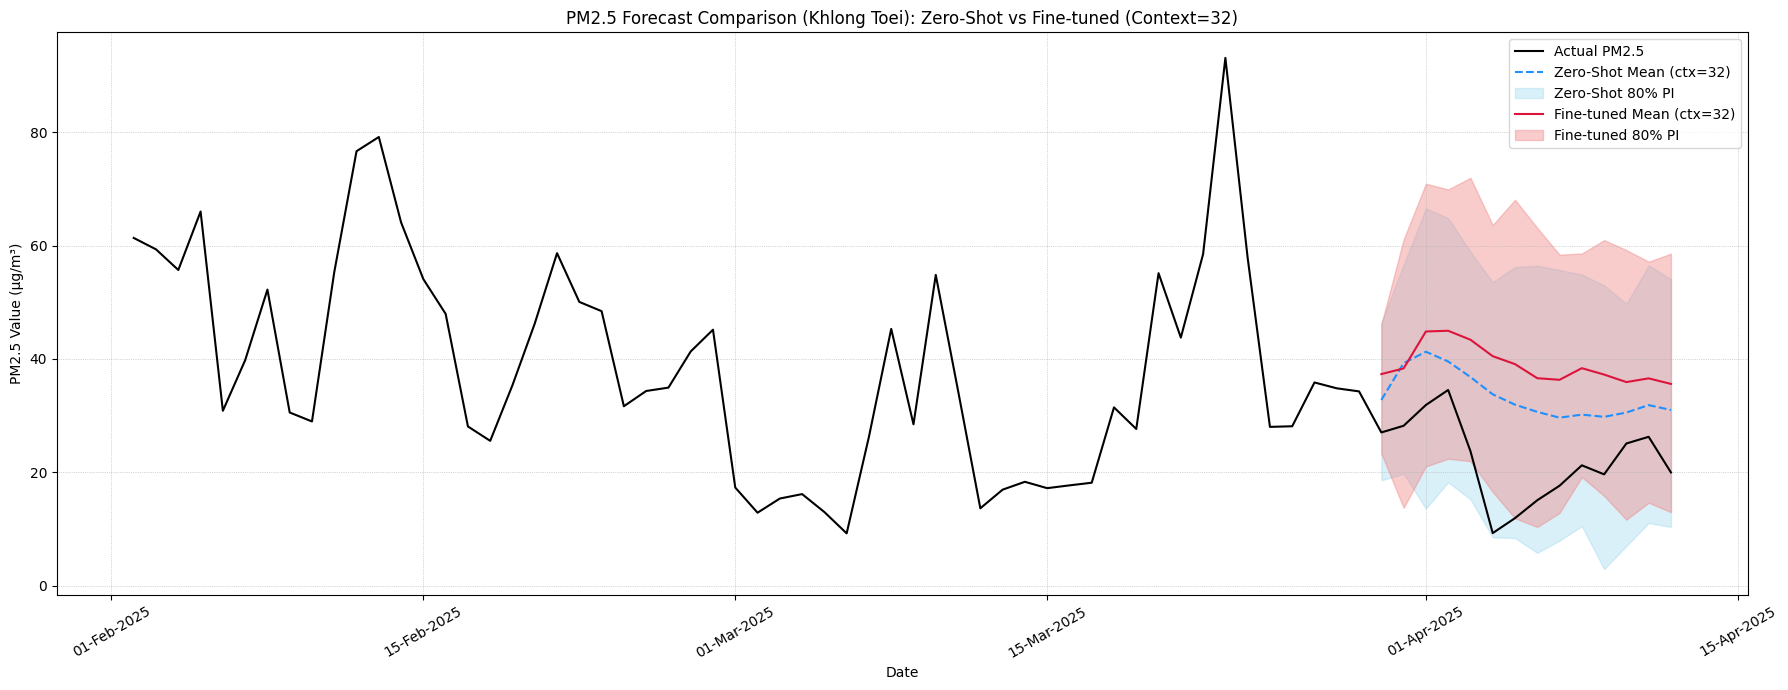


--- Plotting for context = 64 ---


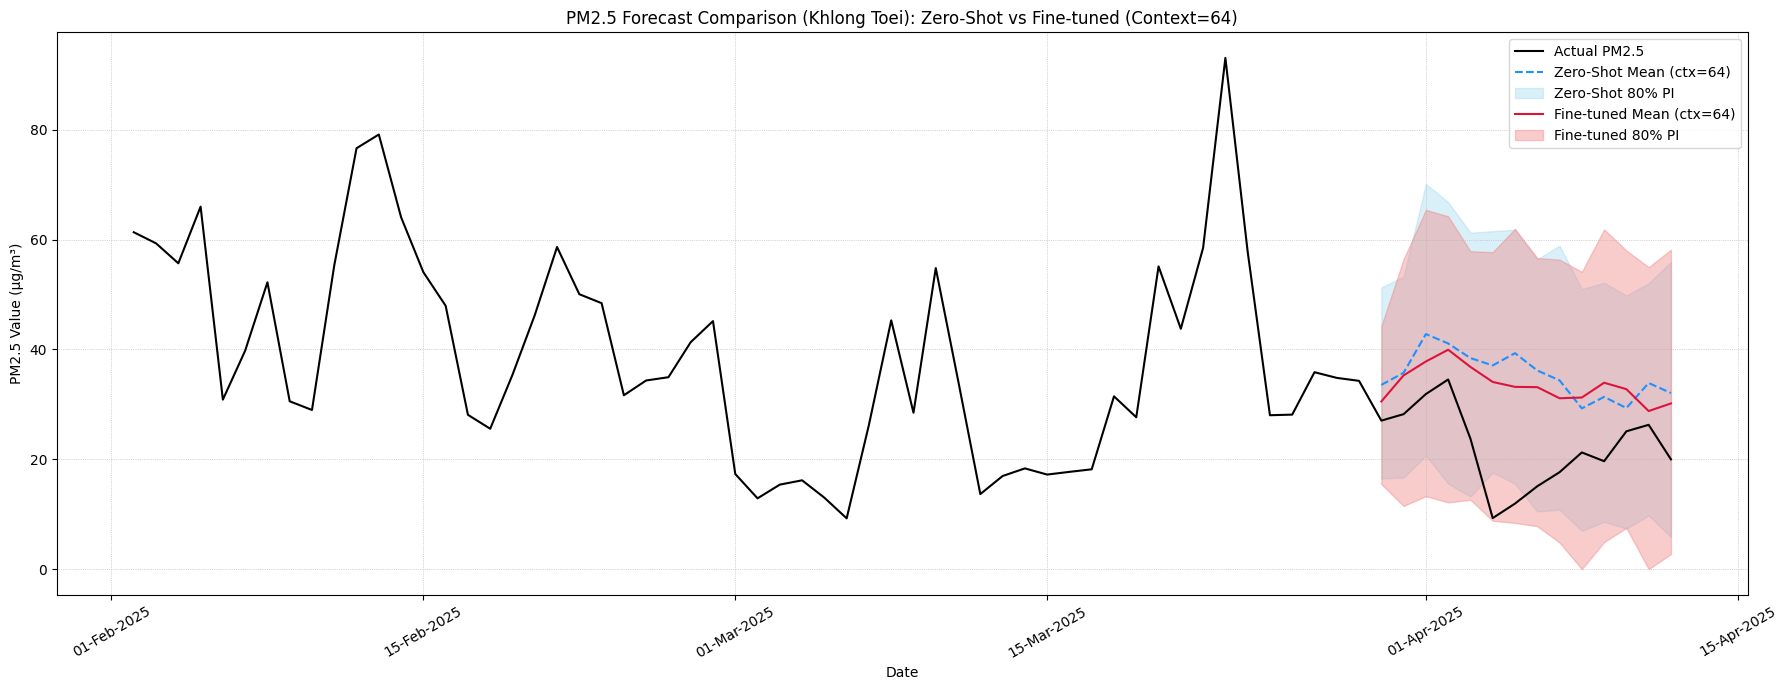


--- Plotting for context = 128 ---


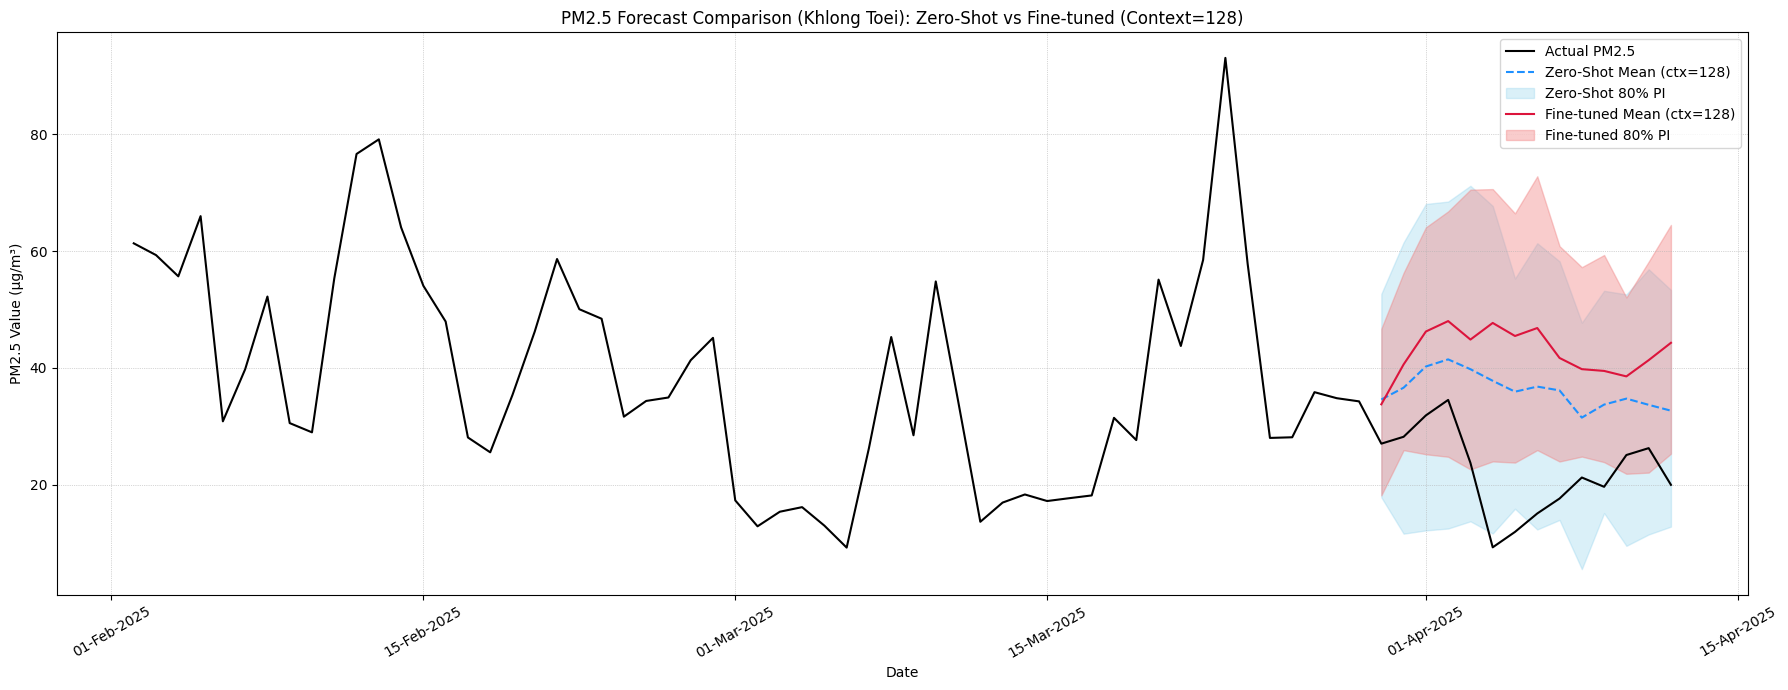


✅ Plotting Complete.


In [ ]:
print("\n--- Plotting Forecast Comparisons ---")

# Use the same list of contexts as the comparison table
for c_plot in contexts_to_compare:
    print(f"\n--- Plotting for context = {c_plot} ---")

    # --- Check if data is available for plotting ---
    # Need forecasts and ground truth from both zero-shot and fine-tuned runs
    has_zs_results = c_plot in results_zero_shot and results_zero_shot[c_plot][0] and results_zero_shot[c_plot][1]
    has_ft_results = c_plot in results_finetuned and results_finetuned[c_plot][0] and results_finetuned[c_plot][1]

    if not has_zs_results:
        print(f"Skipping plot for ctx={c_plot}: Missing Zero-Shot results.")
        continue
    if not has_ft_results:
         print(f"Skipping plot for ctx={c_plot}: Missing Fine-tuned results.")
         continue

    # --- Extract data for the plot ---
    # We typically visualize the forecast for the first time series item (index 0) if multiple exist
    # In this case, we only have one time series ('คลองเตย').
    ts_index = 0 # Index of the time series to plot

    # Get zero-shot forecasts and ground truth
    fc_zero_shot_list, ts_list_zs = results_zero_shot[c_plot]
     # Get fine-tuned forecasts and ground truth (tss list should be identical)
    fc_finetuned_list, ts_list_ft = results_finetuned[c_plot]

    # Select the specific forecast and ground truth objects for the chosen ts_index
    # Ensure index is valid
    if ts_index >= len(ts_list_zs) or ts_index >= len(fc_zero_shot_list) or ts_index >= len(fc_finetuned_list):
         print(f"Warning: Time series index {ts_index} out of bounds for ctx={c_plot}. Skipping plot.")
         continue

    ts_actual = ts_list_zs[ts_index] # Ground truth series (should be same in ts_list_ft)
    fc_zero_shot = fc_zero_shot_list[ts_index] # Zero-shot forecast object
    fc_finetuned = fc_finetuned_list[ts_index] # Fine-tuned forecast object

    # --- Create the plot ---
    plt.figure(figsize=(18, 7))
    date_fmt = mdates.DateFormatter('%d-%b-%Y') # Date formatting for x-axis

    # Define how much history to show before the forecast starts
    plot_history = prediction_length * 5 # Show 5 times the prediction length as history

    # Plot actual historical data
    # Convert Pandas PeriodIndex (from GluonTS) to Timestamps for plotting
    plt.plot(ts_actual[-plot_history:].to_timestamp(), label='Actual PM2.5', color='black', linewidth=1.5)

    # Plot Zero-Shot Forecast
    # Calculate quantiles for prediction interval
    q_low = 0.1  # Lower quantile (e.g., 10th percentile)
    q_high = 0.9 # Upper quantile (e.g., 90th percentile)
    lower_quantile_zs = fc_zero_shot.quantile(q_low)
    upper_quantile_zs = fc_zero_shot.quantile(q_high)
    # Plot mean forecast
    plt.plot(fc_zero_shot.index.to_timestamp(), fc_zero_shot.mean, color='dodgerblue', linestyle='--', label=f'Zero-Shot Mean (ctx={c_plot})')
    # Plot prediction interval
    plt.fill_between(fc_zero_shot.index.to_timestamp(), lower_quantile_zs, upper_quantile_zs,
                     color='skyblue', alpha=0.3, label=f'Zero-Shot {int((q_high-q_low)*100)}% PI')

    # Plot Fine-tuned Forecast
    lower_quantile_ft = fc_finetuned.quantile(q_low)
    upper_quantile_ft = fc_finetuned.quantile(q_high)
    # Plot mean forecast
    plt.plot(fc_finetuned.index.to_timestamp(), fc_finetuned.mean, color='crimson', linestyle='-', label=f'Fine-tuned Mean (ctx={c_plot})')
    # Plot prediction interval
    plt.fill_between(fc_finetuned.index.to_timestamp(), lower_quantile_ft, upper_quantile_ft,
                     color='lightcoral', alpha=0.4, label=f'Fine-tuned {int((q_high-q_low)*100)}% PI')

    # --- Finalize Plot ---
    plt.title(f'PM2.5 Forecast Comparison (Khlong Toei): Zero-Shot vs Fine-tuned (Context={c_plot})')
    plt.xlabel("Date")
    plt.ylabel("PM2.5 Value (µg/m³)") # Add units if known
    plt.gca().xaxis.set_major_formatter(date_fmt) # Format x-axis dates
    plt.xticks(rotation=30) # Rotate date labels for better readability
    plt.legend()
    plt.grid(True, linestyle=':', linewidth=0.5) # Add light grid
    plt.tight_layout() # Adjust plot to prevent labels overlapping
    plt.show() # Display the plot

print("\n✅ Plotting Complete.")